In [257]:
import vbll
# Import necessary packages
import torch
import torch.nn as nn
import numpy as np
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
from omegaconf import OmegaConf

In [258]:
args = OmegaConf.load('colors.yml')

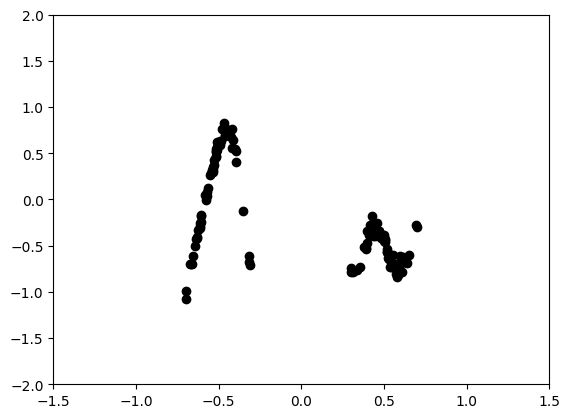

In [228]:
class SimpleFnDataset(Dataset):
    """The simple function used in DUE/SNGP 1-d regression experiments.
    Based on the implementation presented in:
    https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """

    def __init__(self, num_samples):
        self.num_samples = int(num_samples)
        self.X, self.Y = self.get_data()

    def get_data(self, noise=0.05, seed=2):
        np.random.seed(seed)

        W = np.random.randn(30, 1)
        b = np.random.rand(30, 1) * 2 * np.pi

        x = 5 * np.sign(np.random.randn(self.num_samples)) + np.random.randn(self.num_samples).clip(-2, 2)
        y = np.cos(W * x + b).sum(0)/5. + noise * np.random.randn(self.num_samples)
        return torch.tensor(x[..., None]).float()/10, torch.tensor(y[..., None]).float()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def viz_data(dataset):
    plt.scatter(dataset.X, dataset.Y, color='k')
    plt.axis([-1.5, 1.5, -2, 2])
    plt.show()

dataset = SimpleFnDataset(num_samples=128)

viz_data(dataset)

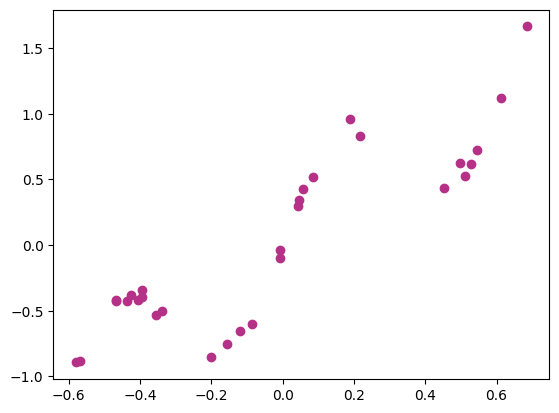

In [216]:
class SimpleFnDataset(Dataset):
    """The simple function used in DUE/SNGP 1-d regression experiments.
    Based on the implementation presented in:
    https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """

    def __init__(self, num_samples):
        self.num_samples = int(num_samples)
        self.X, self.Y = self.get_data()

    def get_data(self, noise=0.05, seed=2):
        x = np.random.uniform(-7, 7, self.num_samples)
        noise = np.random.normal(0, 0.05, size=x.shape)  # Gaussian noise
        y =  np.sin(x) * 0.5 + 0.2 * x + noise

        return torch.tensor(x[..., None]).float()/10, torch.tensor(y[..., None]).float()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def viz_data(dataset):
    plt.scatter(dataset.X, dataset.Y, color =args.red.dark)
    plt.show()

dataset = SimpleFnDataset(num_samples=30)
viz_data(dataset)

In [274]:
class MLP(nn.Module):
  """
  A standard MLP regression model.

  cfg: a config containing model parameters.
  """
  def __init__(self, cfg):
    super(MLP, self).__init__()

    # define model layers
    self.params = nn.ModuleDict({
        'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
        'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
        'out_layer': nn.Linear(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES)
        })

    # ELU activations are an arbitrary choice
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

def train(dataloader, model, train_cfg, verbose = True):
  """Train a standard regression model with MSE loss."""
  loss_fn = nn.MSELoss()

  param_list = model.parameters()
  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  for epoch in range(train_cfg.NUM_EPOCHS + 1):
    model.train()
    running_loss = []

    for train_step, (x, y) in enumerate(dataloader):
      optimizer.zero_grad()

      out = model(x) # compute model output
      loss = loss_fn(out, y) # compute MSE loss

      loss.backward()
      optimizer.step()
      running_loss.append(loss.item())

    if epoch % train_cfg.VAL_FREQ == 0 and verbose:
      print('Epoch {} loss: {:.3f}'.format(epoch, np.mean(running_loss)))
      running_loss = []

In [275]:
class train_cfg:
  NUM_EPOCHS = 1000
  BATCH_SIZE = 32
  LR = 3e-3
  WD = 0.
  OPT = torch.optim.AdamW
  VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4

dataloader = DataLoader(dataset, batch_size=train_cfg.BATCH_SIZE, shuffle=True)
model = MLP(cfg())
train(dataloader, model, train_cfg())

Epoch 0 loss: 0.217
Epoch 100 loss: 0.020
Epoch 200 loss: 0.011
Epoch 300 loss: 0.004
Epoch 400 loss: 0.003
Epoch 500 loss: 0.003
Epoch 600 loss: 0.004
Epoch 700 loss: 0.002
Epoch 800 loss: 0.003
Epoch 900 loss: 0.003
Epoch 1000 loss: 0.003


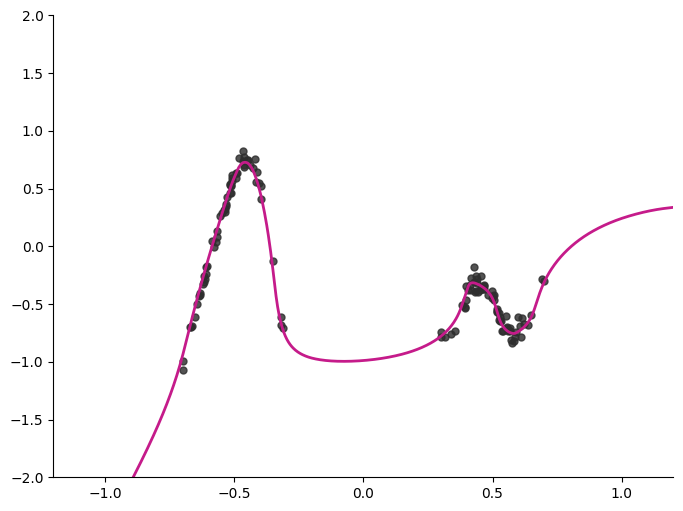

In [289]:
def viz_model(model, dataloader, title=None):
  """Visualize prediction of standard regression model."""
  model.eval()
  X = torch.linspace(-1.5, 1.5, 1000)[..., None]
  Y_pred = model(X)

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  ax.plot(X.detach().numpy(), Y_pred.detach().numpy(), color=args.red.dark, linewidth=2)
  ax.scatter(dataloader.dataset.X, dataloader.dataset.Y, color="#2E2E2ED2", s=25)

  ax.axis([-1.2, 1.2, -2, 2])
  if not title == None:
    plt.title(title)

  plt.savefig('figures/regression.png', dpi=400, bbox_inches='tight')
  plt.show()
  
viz_model(model, dataloader)

In [230]:
class VBLLMLP(nn.Module):
  """
  An MLP model with a VBLL last layer.

  cfg: a config containing model parameters.
  """

  def __init__(self, cfg):
    super(VBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
        'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
        'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
        'out_layer': vbll.Regression(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, cfg.PARAM, prior_scale = cfg.PRIOR_SCALE, wishart_scale = cfg.WISHART_SCALE)
        })

    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [231]:
def train_vbll(dataloader, model, train_cfg, verbose = True):
  """Train a VBLL model."""

  # We explicitly list the model parameters and set last layer weight decay to 0
  # This isn't critical but can help performance.
  param_list = [
      {'params': model.params.in_layer.parameters(), 'weight_decay': train_cfg.WD},
      {'params': model.params.core.parameters(), 'weight_decay': train_cfg.WD},
      {'params': model.params.out_layer.parameters(), 'weight_decay': 0.}
  ]

  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  for epoch in range(train_cfg.NUM_EPOCHS + 1):
    model.train()
    running_loss = []

    for train_step, (x, y) in enumerate(dataloader):
      optimizer.zero_grad()
      out = model(x)
      loss = out.train_loss_fn(y) # note we use the output of the VBLL layer for the loss

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg.CLIP_VAL)
      optimizer.step()
      running_loss.append(loss.item())

    if epoch % train_cfg.VAL_FREQ == 0 and verbose:
      print('Epoch: {:4d},  loss: {:10.4f}'.format(epoch, np.mean(running_loss)))
      running_loss = []

In [271]:
class train_cfg:
  NUM_EPOCHS = 1000
  BATCH_SIZE = 32
  LR = 1e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4
    REG_WEIGHT = 1./dataset.__len__()
    PARAM = 'diagonal'
    PRIOR_SCALE = 1.
    WISHART_SCALE = .1

vbll_model = VBLLMLP(cfg())
train_vbll(dataloader, vbll_model, train_cfg())

Epoch:    0,  loss:    17.5696
Epoch:  100,  loss:     8.8857
Epoch:  200,  loss:     4.0223
Epoch:  300,  loss:     1.6186
Epoch:  400,  loss:     0.4971
Epoch:  500,  loss:    -0.0986
Epoch:  600,  loss:    -0.4625
Epoch:  700,  loss:    -0.6728
Epoch:  800,  loss:    -0.8177
Epoch:  900,  loss:    -0.8690
Epoch: 1000,  loss:    -0.9681


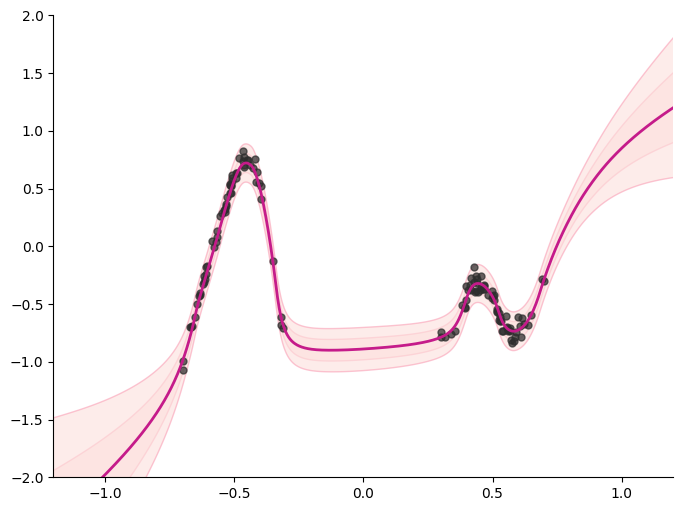

In [290]:
def viz_vbll_model(model, dataloader, stdevs = 1., title = None):
  """Visualize VBLL model predictions, including predictive uncertainty."""
  model.eval()
  X = torch.linspace(-1.5, 1.5, 1000)[..., None]
  Xp = X.detach().numpy().squeeze()

  Y_pred = model(X).predictive
  Y_mean = Y_pred.mean.detach().numpy().squeeze()
  Y_stdev = torch.sqrt(Y_pred.covariance.squeeze()).detach().numpy()

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  ax.plot(Xp, Y_mean, color=args.red.dark, linewidth=2.0)
  plt.fill_between(Xp, Y_mean - stdevs * Y_stdev, Y_mean + stdevs * Y_stdev, alpha=0.6, facecolor=args.red.light, edgecolor=args.red.mid, linewidth=1)
  ax.fill_between(Xp, Y_mean - 2 * stdevs * Y_stdev, Y_mean + 2 * stdevs * Y_stdev, alpha=0.6, facecolor=args.red.light, edgecolor=args.red.mid, linewidth=1)
  ax.scatter(dataloader.dataset.X, dataloader.dataset.Y, color="#2E2E2EB9", s=25)

  ax.axis([-1.2, 1.2, -2, 2])
  if not title == None:
    plt.title(title)

  # plt.show()
  plt.savefig('figures/vbll_regression.png', dpi=400, bbox_inches='tight')

viz_vbll_model(vbll_model, dataloader)